# Analysis - Different Size of Dataset
- $A + B$
- $A$, $B$ : 3-digits interger
- Size of dataset: 100000, 50000, 10000 or 5000

In [1]:
from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Parameters Config

In [2]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [3]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    
    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)

In [4]:
TRAINING_SIZE = [100000, 50000, 10000, 5000]
DIGITS = 3
REVERSE = False
MAXLEN = DIGITS + 1 + DIGITS
chars = '0123456789+ '
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1
ctable = CharacterTable(chars)

## Data Generation

In [5]:
questions = {}
expected = {}
for size in TRAINING_SIZE:
    questions[size] = []
    expected[size] = []
    seen = set()
    print('Generating data of size %d ...' %size)
    while len(questions[size]) < size:
        f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
        a, b = f(), f()
        key = tuple(sorted((a, b)))
        if key in seen:
            continue
        seen.add(key)
        q = '{}+{}'.format(a, b)
        query = q + ' ' * (MAXLEN - len(q))
        ans = str(a + b)
        ans += ' ' * (DIGITS + 1 - len(ans))
        if REVERSE:
            query = query[::-1]
        questions[size].append(query)
        expected[size].append(ans)
    print('Total addition questions:', len(questions[size]))

Generating data of size 100000 ...
Total addition questions: 100000
Generating data of size 50000 ...
Total addition questions: 50000
Generating data of size 10000 ...
Total addition questions: 10000
Generating data of size 5000 ...
Total addition questions: 5000


## Processing

In [6]:
x = {}
y = {}
for size in TRAINING_SIZE:
    print('Vectorization of size %d ...' %size)
    x[size] = np.zeros((len(questions[size]), MAXLEN, len(chars)), dtype=np.bool)
    y[size] = np.zeros((len(expected[size]), DIGITS + 1, len(chars)), dtype=np.bool)
    for i, sentence in enumerate(questions[size]):
        x[size][i] = ctable.encode(sentence, MAXLEN)
    for i, sentence in enumerate(expected[size]):
        y[size][i] = ctable.encode(sentence, DIGITS + 1)

Vectorization of size 100000 ...
Vectorization of size 50000 ...
Vectorization of size 10000 ...
Vectorization of size 5000 ...


In [7]:
x_train, y_train, x_val, y_val, test_x, test_y = {}, {}, {}, {}, {}, {}
for size in TRAINING_SIZE:
    indices = np.arange(len(y[size]))
    np.random.shuffle(indices)
    x[size] = x[size][indices]
    y[size] = y[size][indices]

    # train_test_split
    split_at = len(x[size]) // 5
    train_x = x[size][:split_at]
    train_y = y[size][:split_at]
    test_x[size] = x[size][split_at:]
    test_y[size] = y[size][split_at:]

    split_at = len(train_x) - len(train_x) // 10
    (x_train[size], x_val[size]) = train_x[:split_at], train_x[split_at:]
    (y_train[size], y_val[size]) = train_y[:split_at], train_y[split_at:]

    print('Training Data of size %d:' %size)
    print(x_train[size].shape)
    print(y_train[size].shape)

    print('Validation Data of size %d:' %size)
    print(x_val[size].shape)
    print(y_val[size].shape)

    print('Testing Data of size %d:' %size)
    print(test_x[size].shape)
    print(test_y[size].shape)

Training Data of size 100000:
(18000, 7, 12)
(18000, 4, 12)
Validation Data of size 100000:
(2000, 7, 12)
(2000, 4, 12)
Testing Data of size 100000:
(80000, 7, 12)
(80000, 4, 12)
Training Data of size 50000:
(9000, 7, 12)
(9000, 4, 12)
Validation Data of size 50000:
(1000, 7, 12)
(1000, 4, 12)
Testing Data of size 50000:
(40000, 7, 12)
(40000, 4, 12)
Training Data of size 10000:
(1800, 7, 12)
(1800, 4, 12)
Validation Data of size 10000:
(200, 7, 12)
(200, 4, 12)
Testing Data of size 10000:
(8000, 7, 12)
(8000, 4, 12)
Training Data of size 5000:
(900, 7, 12)
(900, 4, 12)
Validation Data of size 5000:
(100, 7, 12)
(100, 4, 12)
Testing Data of size 5000:
(4000, 7, 12)
(4000, 4, 12)


## Build Model

In [10]:
models = {}
for size in TRAINING_SIZE:
    print('Build model of data size %d ...' %size)
    model = Sequential()
    model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
    model.add(layers.RepeatVector(DIGITS + 1))
    for j in range(LAYERS):
        model.add(RNN(HIDDEN_SIZE, return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    models[size] = model

Build model of data size 100000 ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 4, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________
Build model of data size 50000 ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 128)               72192     

## Training

In [11]:
hist = {}
for size in TRAINING_SIZE:
    print('Train model of data size %d ...' %size)
    hist[size] = models[size].fit(x_train[size], y_train[size],
                                  batch_size=BATCH_SIZE,
                                  epochs=100, verbose=0,
                                  validation_data=(x_val[size], y_val[size]))

Train model of data size 100000 ...
Train model of data size 50000 ...
Train model of data size 10000 ...
Train model of data size 5000 ...


## Visualization

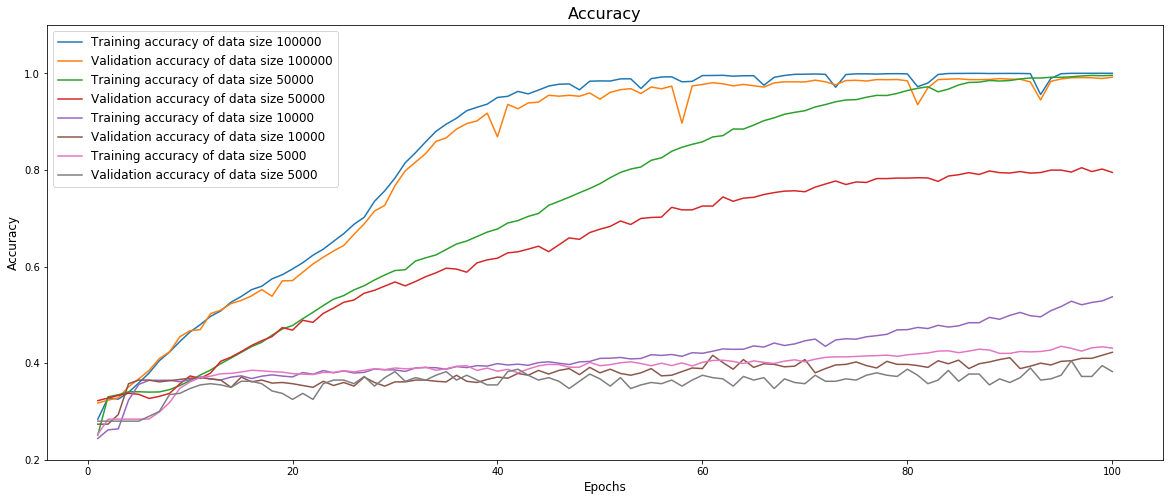

In [12]:
plt.figure(figsize=(20,8))
for size in TRAINING_SIZE:
    acc = hist[size].history['acc']
    val_acc = hist[size].history['val_acc']
    epochs = range(1, 101)
    plt.plot(epochs, acc, label='Training accuracy of data size %d' %size)
    plt.plot(epochs, val_acc, label='Validation accuracy of data size %d' %size)
plt.title('Accuracy', fontsize=16)
plt.ylim([0.2 , 1.1])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.show()

## Testing

In [13]:
print("MSG : Prediction")
for size in TRAINING_SIZE:
    N_corr = 0
    for i in range(len(test_x[size])):
        ind = i
        rowx, rowy = test_x[size][np.array([ind])], test_y[size][np.array([ind])]
        preds = models[size].predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        if correct == guess:
            N_corr += 1
    print('Accuracy of data size %d:' %size, N_corr / len(test_x[size]))

MSG : Prediction
Accuracy of data size 100000: 0.9651625
Accuracy of data size 50000: 0.41055
Accuracy of data size 10000: 0.01425
Accuracy of data size 5000: 0.0075


## Conclusion
- 可以發現隨著 dataset 的大小下降時，training accuracy 與 validation accuracy 會出現較大的差異，也就是較容易出現 overfitting 的情況。
- 而當 dataset 過小時，會導致 model 幾乎不能收斂，在 training accuracy 與 validation accuracy 都很難有所進步。